# 06. Basic Modeling

Use the dataset created in notebook 03:

- The events for the combinations session_id and level_group (therefore each question)
are limited to the first 100 events.
- A total sample size of 2000 unique session_ids is used.
- Train session_ids: 1400
- Validation session_ids: 300
- Test session_ids: 300

In [1]:
import pandas as pd
import numpy as np

import gc
from typing import Tuple

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from keras import optimizers
from keras import callbacks


from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

import matplotlib.pyplot as plt
import seaborn as sns
import yellowbrick as yb

2023-02-26 10:11:06.531362: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-26 10:11:07.022280: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-26 10:11:07.022320: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-26 10:11:07.022325: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

## Load the prepared and vectorized data

In [2]:
X_train = np.load('data/03/X_train.npz')['arr_0']
X_val = np.load('data/03/X_val.npz')['arr_0']
X_test = np.load('data/03/X_test.npz')['arr_0']

y_train = np.load('data/03/y_train.npz')['arr_0']
y_val = np.load('data/03/y_val.npz')['arr_0']
y_test = np.load('data/03/y_test.npz')['arr_0']

gc.collect()

69

In [3]:
print('X_train.shape:', X_train.shape)
print('X_val.shape:', X_val.shape)
print('X_test.shape:', X_test.shape)

print('y_train.shape:', y_train.shape)
print('y_val.shape:', y_val.shape)
print('y_test.shape:', y_test.shape)

X_train.shape: (25200, 100, 340)
X_val.shape: (5400, 100, 340)
X_test.shape: (5400, 100, 340)
y_train.shape: (25200,)
y_val.shape: (5400,)
y_test.shape: (5400,)


## Modeling Functions

In [4]:
def plot_loss(history: callbacks.History, figsize: Tuple[int, int] = (5, 3)) -> None:
    """
    Plot the loss and validation loss.

    Parameters
    ----------
    history : keras.callbacks.History
        The history of the model training.
    """
    epochs = range(1, len(history.history['accuracy']) + 1)

    # summarize history for loss
    plt.figure(figsize=figsize)
    plt.plot(epochs, history.history['loss'])
    
    if ('val_loss' in history.history):
        plt.plot(epochs, history.history['val_loss'])
        plt.legend(['Training loss', 'Validation loss'], loc='upper left')
        plt.title('Training and validation loss')
    else:
        plt.title('Training loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.show()        

In [5]:
def plot_accuracy(history: callbacks.History, figsize: Tuple[int, int] = (5, 3)) -> None:
    """
    Plot the accuracy and validation accuracy.

    Parameters
    ----------
    history : keras.callbacks.History
        The history of the model training.
    """
    epochs = range(1, len(history.history['accuracy']) + 1)

    # summarize history for accuracy
    plt.figure(figsize=figsize)
    plt.plot(epochs, history.history['accuracy'])

    if ('val_accuracy' in history.history):
        plt.plot(epochs, history.history['val_accuracy'])
        plt.legend(['Training acc', 'Validation acc'], loc='upper left')
        plt.title('Training and validation accuracy')
    else:
        plt.title('Training accuracy')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.show()

In [6]:
def optimize_f1(y_true: np.ndarray, y_score: np.ndarray) -> Tuple[float, float, float]:
    """
    Optimize the F1 score.

    Parameters
    ----------
    y_true : np.ndarray
        The true labels.
    y_score : np.ndarray
        The predicted labels.

    Returns
    -------
    Tuple[float, float, float]
        The optimized threshold, precision, and recall.
    """
    best_f1 = 0
    best_threshold = 0
    best_precision = 0
    best_recall = 0

    for threshold in np.arange(0, 1, 0.01):
        y_pred = (y_score > threshold).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
        #print(f'Threshold: {threshold:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}')

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            best_precision = precision
            best_recall = recall

    return best_threshold, best_precision, best_recall

In [7]:
def train_model(
        model,
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_val : np.ndarray,
        y_val: np.ndarray,
        epochs: int,
        batch_size: int,
        optimizer,
        loss: str,
        metrics: list) -> callbacks.History:
    """
    Train the keras model based on the parameters.

    Parameters
    ----------
    model : keras.models
        The model to train.
    X_train : np.ndarray
        The training data.
    y_train : np.ndarray
        The training labels.
    X_val : np.ndarray
        The validation data.
    y_val : np.ndarray
        The validation labels.
    epochs : int
        The number of epochs.
    batch_size : int
        The batch size.
    optimizer : keras.optimizers
        The optimizer.
    loss : str
        The loss function.
    metrics : list
        The metrics.
    
    Returns
    -------
    keras.callbacks.History
        The history of the training.
    """
    # compile the model
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics)
    
    # fit the model
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val))
    
    return history

# # the model training
# history = train_model(
#     model=model,
#     X_train=X_train,
#     y_train=y_train,
#     X_val=X_val,
#     y_val=y_val,
#     epochs=epochs,
#     batch_size=batch_size,
#     optimizer=optimizers.RMSprop(learning_rate=learning_rate),
#     loss=loss,
#     metrics=metrics)

In [8]:
# function to plot the history, test the model based on the test data, and optimize the threshold for the f1 score and plot the classification report
def test_model(
        model,
        history: callbacks.History,
        X_test: np.ndarray,
        y_test: np.ndarray) -> float:
    """
    Test the model based on the test data.

    Parameters
    ----------
    model : keras.models
        The model to test.
    history : keras.callbacks.History
        The history of the training.
    X_test : np.ndarray
        The test data.
    y_test : np.ndarray
        The test labels.

    Returns
    -------
    float
        The optimized threshold for the best F1 score.
    """
    
    plot_loss(history)
    plot_accuracy(history)

    y_test_score = model.predict(X_test)
    threshold, _, _ = optimize_f1(y_test, y_test_score)

    print(classification_report(y_test, y_test_score > threshold))
    print(f'Optimized threshold for best F1: {threshold:.2f}')

    gc.collect()

    return threshold

# # test the model
# test_model(model, history, X_test, y_test)

In [9]:
# function to train and test the model
def train_and_test_model(
        model,
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_val : np.ndarray,
        y_val: np.ndarray,
        X_test: np.ndarray,
        y_test: np.ndarray,
        epochs: int,
        batch_size: int,
        optimizer,
        loss: str,
        metrics: list) -> float:
    """
    Train and test the model.

    Parameters
    ----------
    model : keras.models
        The model to train and test.
    X_train : np.ndarray
        The training data.
    y_train : np.ndarray
        The training labels.
    X_val : np.ndarray
        The validation data.
    y_val : np.ndarray
        The validation labels.
    X_test : np.ndarray
        The test data.
    y_test : np.ndarray
        The test labels.
    epochs : int
        The number of epochs.
    batch_size : int
        The batch size.
    optimizer : keras.optimizers
        The optimizer.
    loss : str
        The loss function.
    metrics : list
        The metrics.

    Returns
    -------
    float
        The optimized threshold for the best F1 score.
    """
    history = train_model(
        model=model,
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        loss=loss,
        metrics=metrics)
    
    gc.collect()

    return test_model(model, history, X_test, y_test)

# # train and test the model
# train_and_test_model(
#     model=model,
#     X_train=X_train,
#     y_train=y_train,
#     X_val=X_val,
#     y_val=y_val,
#     X_test=X_test,
#     y_test=y_test,
#     epochs=epochs,
#     batch_size=batch_size,
#     optimizer=optimizers.RMSprop(learning_rate=learning_rate),
#     loss=loss,
#     metrics=metrics)

In [10]:
def global_train_model(model,
                       epochs: int,
                       batch_size: int,
                       optimizer,
                       loss: str,
                       metrics: list) -> float:
        """
        Train the model using the global data.

        Parameters
        ----------
        model : keras.models
                The model to train.
        epochs : int
                The number of epochs.
        batch_size : int
                The batch size.
        optimizer : keras.optimizers
                The optimizer.
        loss : str
                The loss function.
        metrics : list
                The metrics.

        Returns
        -------
        float
                The optimized threshold for the best F1 score.
        """
        global X_train
        global y_train
        global X_val
        global y_val
        global X_test
        global y_test

        return train_and_test_model(
                model=model,
                X_train=X_train,
                y_train=y_train,
                X_val=X_val,
                y_val=y_val,
                X_test=X_test,
                y_test=y_test,
                epochs=epochs,
                batch_size=batch_size,
                optimizer=optimizer,
                loss=loss,
                metrics=metrics)

## Simple Flattening

A very simple model that is not considering the sequence of events and flattens the input data.

In [11]:
# parameters
learning_rate = 0.001
dense_layer_size = 32
epochs = 10
batch_size = 10

loss = 'binary_crossentropy'
metrics = ['accuracy']

In [12]:
# define the model
model = Sequential()
model.add(layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.Dense(dense_layer_size, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

2023-02-26 10:11:27.694718: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-26 10:11:27.708953: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-26 10:11:27.709096: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-26 10:11:27.709584: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

2023-02-26 10:11:28.652169: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3427200000 exceeds 10% of free system memory.
2023-02-26 10:11:29.953564: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3427200000 exceeds 10% of free system memory.


Epoch 1/10
 120/2520 [>.............................] - ETA: 3s - loss: 0.5922 - accuracy: 0.7008

2023-02-26 10:11:31.558195: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2520/2520 [==============================] - 5s 2ms/step - loss: 0.5561 - accuracy: 0.7318 - val_loss: 0.5429 - val_accuracy: 0.7400
Epoch 2/10
2520/2520 [==============================] - 4s 2ms/step - loss: 0.5216 - accuracy: 0.7448 - val_loss: 0.5249 - val_accuracy: 0.7524
Epoch 3/10
2520/2520 [==============================] - 4s 1ms/step - loss: 0.5137 - accuracy: 0.7498 - val_loss: 0.5223 - val_accuracy: 0.7457
Epoch 4/10
2520/2520 [==============================] - 4s 1ms/step - loss: 0.5110 - accuracy: 0.7550 - val_loss: 0.5304 - val_accuracy: 0.7437
Epoch 5/10
2520/2520 [==============================] - 4s 1ms/step - loss: 0.5089 - accuracy: 0.7556 - val_loss: 0.5323 - val_accuracy: 0.7446
Epoch 6/10
2520/2520 [==============================] - 4s 1ms/step - loss: 0.5079 - accuracy: 0.7585 - val_loss: 0.5326 - val_accuracy: 0.7376
Epoch 7/10
2520/2520 [==============================] - 4s 2ms/step - loss: 0.5044 - accuracy: 0.7612 - val_loss: 0.5261 - val_accuracy: 0.7398
Epo

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


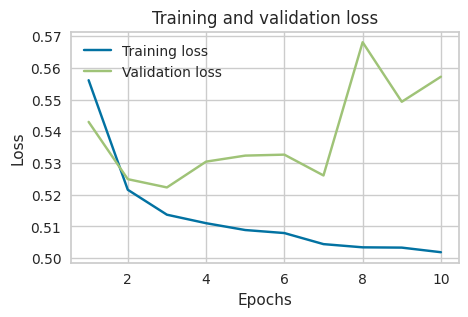

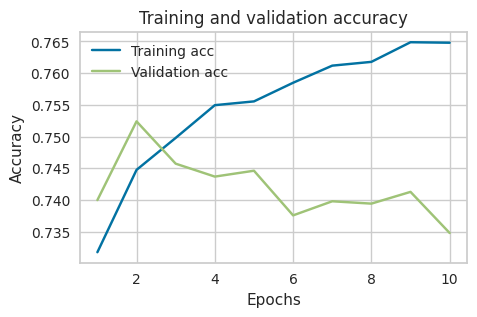

169/169 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.50      0.54      0.52      1555
           1       0.81      0.79      0.80      3845

    accuracy                           0.71      5400
   macro avg       0.66      0.66      0.66      5400
weighted avg       0.72      0.71      0.72      5400

Optimized threshold for best F1: 0.63


/home/vscode/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.63

In [13]:
global_train_model(
    model=model,
    epochs=epochs,
    batch_size=batch_size,
    optimizer=optimizers.RMSprop(learning_rate=learning_rate),
    loss=loss,
    metrics=metrics)